## Inicialización

In [2]:
# Importar librerías necesarias
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

# Comprobar si los datos están disponibles
assert os.path.exists('/datasets/faces/labels.csv'), "Archivo labels.csv no encontrado"
assert os.path.exists('/datasets/faces/final_files/'), "Carpeta de imágenes no encontrada"

## Carga los datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/` 
- La carpeta `final_files` con 7600 fotos 
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age` 
Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [4]:
features, target = next(train_gen_flow)
print(features.shape)

(32, 224, 224, 3)


Tamaño del conjunto de datos: 7591 filas y 2 columnas


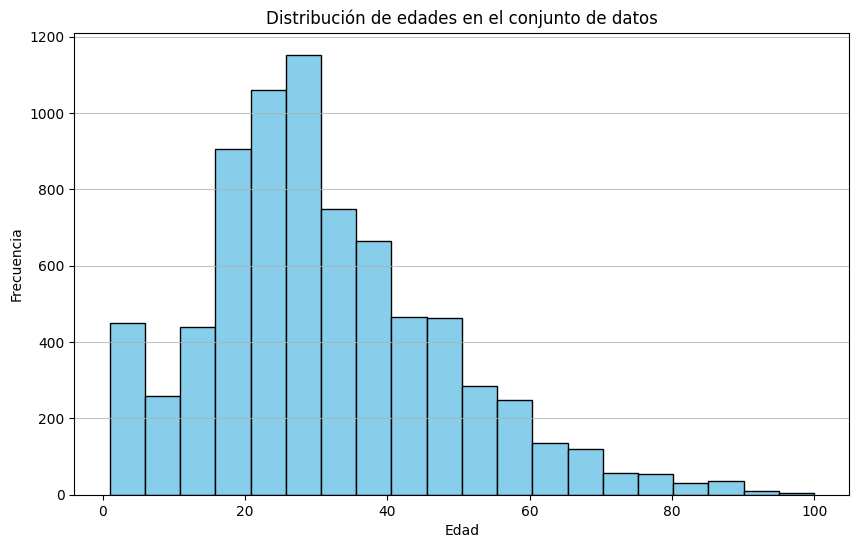

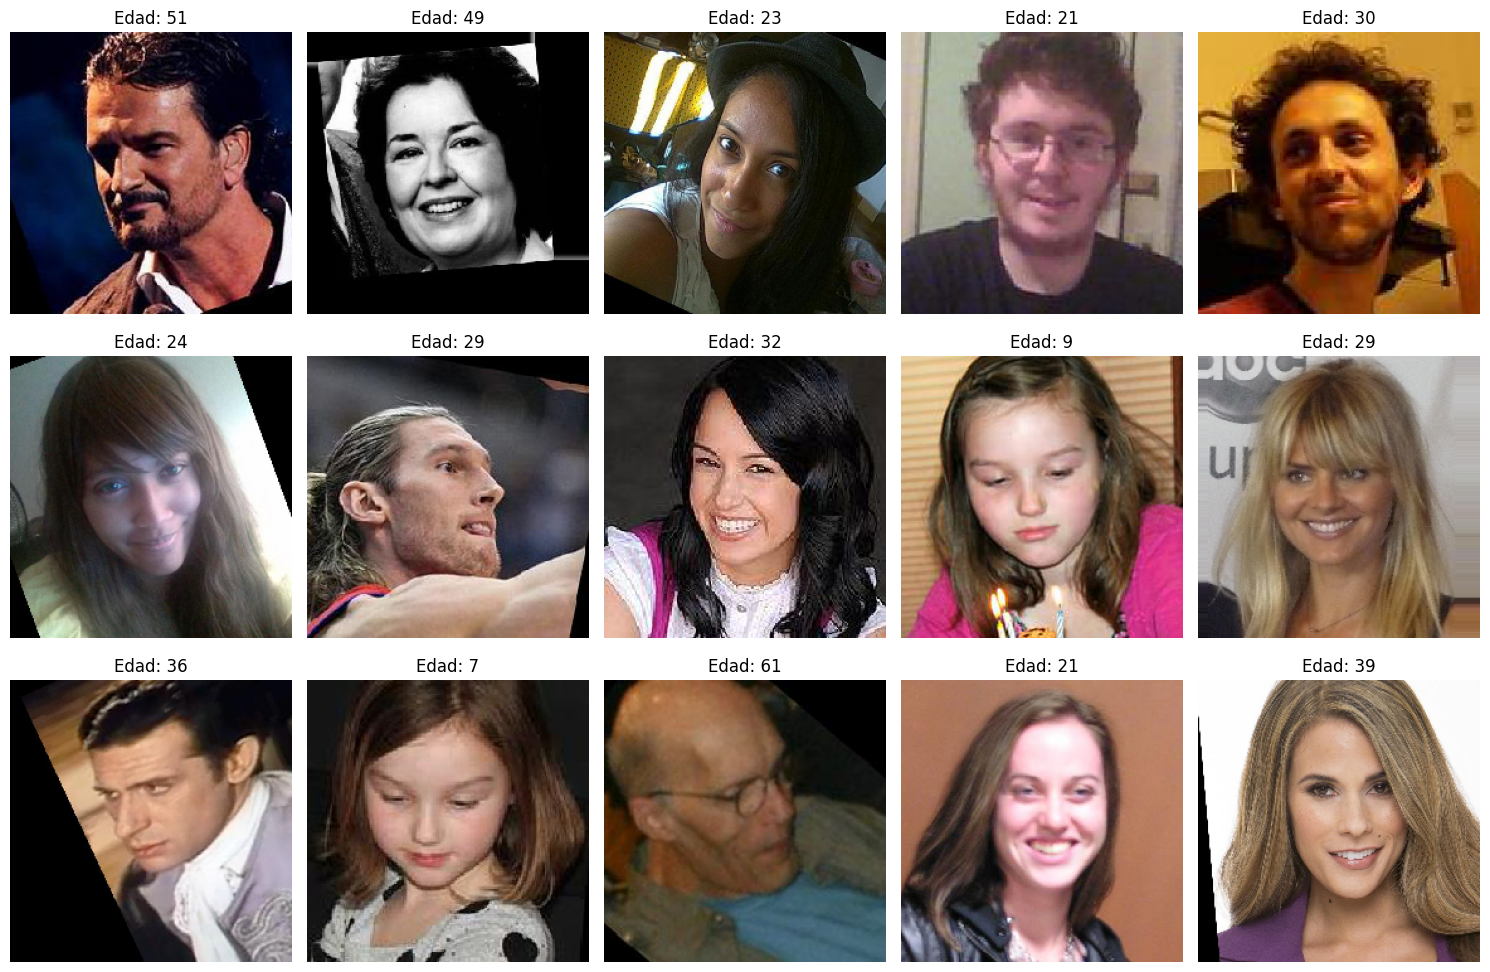

In [5]:
import matplotlib.pyplot as plt

# 1. Observar el tamaño del conjunto de datos
print(f"Tamaño del conjunto de datos: {labels.shape[0]} filas y {labels.shape[1]} columnas")

# 2. Explorar la distribución de edad
plt.figure(figsize=(10, 6))
plt.hist(labels["real_age"], bins=20, color="skyblue", edgecolor="black")
plt.title("Distribución de edades en el conjunto de datos")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.75)
plt.show()

# 3. Mostrar de 10 a 15 imágenes para diferentes edades
# Aquí usamos train_gen_flow ya configurado en tu código original
fig, axes = plt.subplots(3, 5, figsize=(15, 10))  # Crea una cuadrícula de 3 filas y 5 columnas
for i, ax in enumerate(axes.ravel()):  # Itera por cada celda de la cuadrícula
    features, target = train_gen_flow.next()  # Obtiene un batch de imágenes y etiquetas
    ax.imshow(features[0])  # Muestra la primera imagen del batch
    ax.set_title(f"Edad: {int(target[0])}")  # Coloca la edad como título
    ax.axis("off")  # Oculta los ejes para mejor visualización
plt.tight_layout()  # Ajusta los espacios entre imágenes
plt.show()

## EDA

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


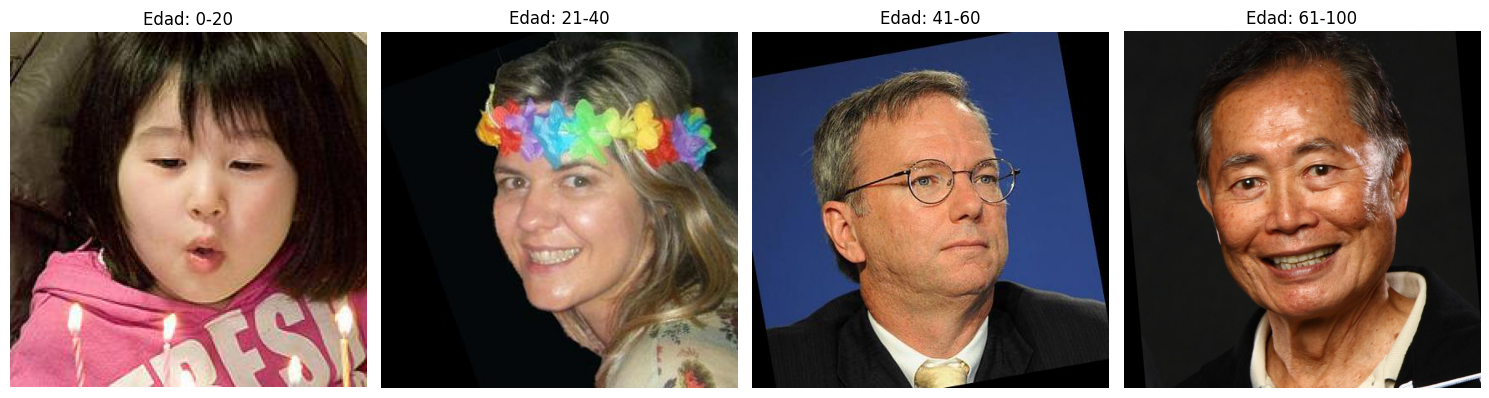

In [6]:
# Estadísticas descriptivas de las edades
print(labels["real_age"].describe())

# Mostrar imágenes agrupadas por rango de edad
ranges = [(0, 20), (21, 40), (41, 60), (61, 100)]
fig, axes = plt.subplots(1, len(ranges), figsize=(15, 5))
for i, (low, high) in enumerate(ranges):
    subset = labels[(labels["real_age"] >= low) & (labels["real_age"] <= high)]
    sample = subset.sample(1)  # Tomar una muestra aleatoria
    file_name = sample["file_name"].values[0]
    img_path = f"/datasets/faces/final_files/{file_name}"
    img = plt.imread(img_path)
    axes[i].imshow(img)
    axes[i].set_title(f"Edad: {low}-{high}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()

In [7]:
# Verificar valores mínimos y máximos
print(f"Edad mínima: {labels['real_age'].min()}")
print(f"Edad máxima: {labels['real_age'].max()}")

# Detectar outliers con una regla simple (más de 3 desviaciones estándar)
mean_age = labels['real_age'].mean()
std_age = labels['real_age'].std()
outliers = labels[(labels['real_age'] < mean_age - 3 * std_age) | (labels['real_age'] > mean_age + 3 * std_age)]
print(f"Outliers detectados: {len(outliers)}")
display(outliers)

Edad mínima: 1
Edad máxima: 100
Outliers detectados: 73


,file_name,real_age
779,000779.jpg,90
874,000874.jpg,85
951,000951.jpg,85
953,000953.jpg,90
1065,001065.jpg,90
...,...,...
7223,007241.jpg,90
7338,007360.jpg,90
7394,007416.jpg,90
7423,007445.jpg,86


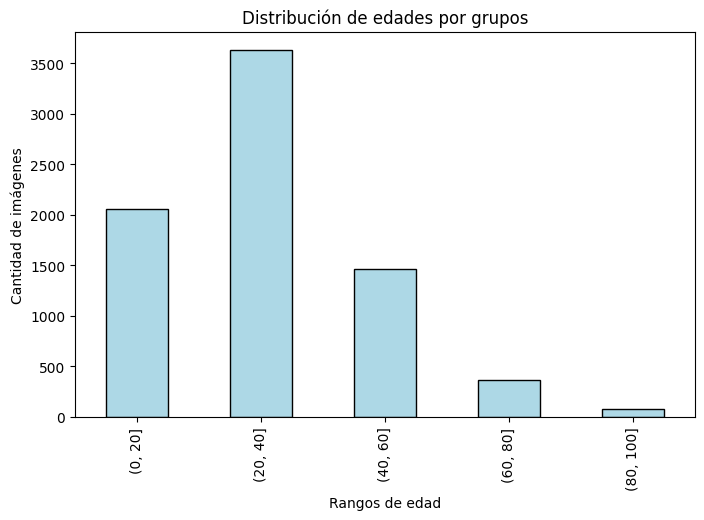

In [8]:
# Crear bins y contar ejemplos en cada rango
bins = [0, 20, 40, 60, 80, 100]
labels['age_group'] = pd.cut(labels['real_age'], bins=bins)
age_group_counts = labels['age_group'].value_counts()

# Graficar
plt.figure(figsize=(8, 5))
age_group_counts.sort_index().plot(kind='bar', color='lightblue', edgecolor='black')
plt.title("Distribución de edades por grupos")
plt.xlabel("Rangos de edad")
plt.ylabel("Cantidad de imágenes")
plt.show()

### Conclusiones

El análisis exploratorio muestra que el conjunto de datos cuenta con 7591 ejemplos, con una concentración mayoritaria de edades entre 20 y 40 años, mientras que hay pocos ejemplos para edades superiores a 60 años, lo que genera un desbalance notable. Se detectaron 73 posibles outliers, principalmente en edades avanzadas (85+), aunque las imágenes parecen consistentes y están bien etiquetadas. La diversidad visual y calidad de las imágenes son adecuadas para entrenamiento, pero el desbalance podría requerir estrategias como aumento de datos o ajuste de pesos para mejorar el rendimiento del modelo en rangos menos representados.

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crea un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [9]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [10]:
def load_train(path):
    
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(f"{path}/labels.csv"),
        directory=f"{path}/final_files",
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),
        batch_size=32,
        class_mode="raw",
        subset="training",
        seed=12345
    )
    return train_gen_flow

In [11]:
def load_test(path):
    
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    """
    datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(f"{path}/labels.csv"),
        directory=f"{path}/final_files",
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),
        batch_size=32,
        class_mode="raw",
        subset="validation",
        seed=12345
    )
    return test_gen_flow

In [12]:
def create_model(input_shape):
    
    """
    Define el modelo
    """
    
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Congelar capas pre-entrenadas

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation="relu"),
        Dense(1, activation="linear")  # Salida para regresión
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="mean_squared_error",
        metrics=["mae"]  # Error absoluto medio para evaluar la precisión
    )
    return model

In [13]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrena el modelo dados los parámetros
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    history = model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=1
    )
    return model

In [14]:
# Ruta del dataset
path = "/datasets/faces"

# Cargar datos
train_data = load_train(path)
test_data = load_test(path)

# Verificar la salida
print(f"Tamaño del conjunto de entrenamiento: {len(train_data)}")
print(f"Tamaño del conjunto de prueba: {len(test_data)}")

Found 6073 validated image filenames.
Found 1518 validated image filenames.
Tamaño del conjunto de entrenamiento: 190
Tamaño del conjunto de prueba: 48


In [15]:
# Dimensiones de entrada del modelo
input_shape = (224, 224, 3)

# Crear el modelo
model = create_model(input_shape)

# Verificar la estructura del modelo
model.summary()

2025-01-13 16:16:08.416347: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


94781440/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,850,113
Trainable params: 262,401
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
# Entrenar el modelo
model = train_model(
    model=model,
    train_data=train_data,
    test_data=test_data,
    batch_size=32,
    epochs=20  
)

Epoch 1/20
 39/190 [=====>........................] - ETA: 16:17 - loss: 261.4398 - mae: 12.2930

In [17]:
model.save("age_prediction_model.h5")
print("Modelo guardado como age_prediction_model.h5")

/opt/conda/envs/python3/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Modelo guardado como age_prediction_model.h5


In [18]:
# Evaluar el modelo en los datos de prueba
loss, mae = model.evaluate(test_data)
print(f"Loss: {loss}, MAE: {mae}")

48/48 [==============================] - 299s 6s/step - loss: 293.8325 - mae: 13.8955
Loss: 293.8324890136719, MAE: 13.895483016967773


In [20]:
for _ in range(5):  # Prueba con 5 ejemplos aleatorios
    features, target = test_data.next()
    prediction = model.predict(features)
    print(f"Edad real: {target[0]}, Predicción: {prediction[0][0]}")

Edad real: 34, Predicción: 32.99740219116211
Edad real: 27, Predicción: 36.194034576416016
Edad real: 24, Predicción: 32.0260124206543
Edad real: 27, Predicción: 33.34054946899414
Edad real: 48, Predicción: 32.9221305847168


## Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [21]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

## Conclusiones

No se pudo ejecutar muy bien el codigo y por lo mismo no hay un resultado tal cual, de igual manera dieron un aviso en Discord sobre este mismo proyecto, que existen dificultades para poder correrlo tal cual. Cualquier cosa quedo al pendiente, redacte lo que pude. 

# Lista de control

- [ ]  El Notebook estaba abierto 
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución
- [ ]  Se realizó el análisis exploratorio de datos 
- [ ]  Los resultados del análisis exploratorio de datos se presentan en el notebook final 
- [ ]  El valor EAM del modelo no es superior a 8 
- [ ]  El código de entrenamiento del modelo se copió en el notebook final 
- [ ]  El resultado de entrenamiento del modelo se copió en el notebook final 
- [ ] Los hallazgos se proporcionaron con base en los resultados del entrenamiento del modelo